#Dataset Description:
This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.


*   InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

*  StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.


*   Description: Product (item) name. Nominal.
*   Quantity: The quantities of each product (item) per transaction. Numeric.

*   InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
*   UnitPrice: Unit price. Numeric, Product price per unit in sterling.

* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import datetime as dt

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#machine learning algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_excel('/content/train.xlsx')

##Data explore + clean

In [ ]:
df.head() #to view top 5 records

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,558904,22292,HANGING CHICK YELLOW DECORATION,1,2011-07-04 16:18:00,1.25,NaN,United Kingdom
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom
3,541658,21988,PACK OF 6 SKULL PAPER PLATES,1,2011-01-20 12:16:00,0.85,15529.0,United Kingdom
4,538364,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-10 17:26:00,1.95,14448.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379336 entries, 0 to 379335
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    379336 non-null  object        
 1   StockCode    379336 non-null  object        
 2   Description  378373 non-null  object        
 3   Quantity     379336 non-null  int64         
 4   InvoiceDate  379336 non-null  datetime64[ns]
 5   UnitPrice    379336 non-null  float64       
 6   CustomerID   285076 non-null  float64       
 7   Country      379336 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 23.2+ MB


In [ ]:
#checking for missing data
df.isna().sum()

InvoiceNo          0
StockCode          0
Description      963
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     94260
Country            0
dtype: int64

In [ ]:
#percentage of null values
round((df.isnull().sum()/df.shape[0])*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.25
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.85
Country         0.00
dtype: float64

In [ ]:
#droping the rows which has NaNs in CutomerID

df = df.dropna(subset=['CustomerID'])


In [ ]:
#checking for overall null values in the data
df.isna().sum().sum()

0

In [ ]:
#checking for duplicate values
df.duplicated().any()

True

In [ ]:
#total duplicates in the data
df.duplicated().sum()

2656

In [ ]:
#dropping duplicates in the data
df = df.drop_duplicates()

In [ ]:
#checking for duplicates
df.duplicated().sum()

0

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,282420.0,12.110283,297.109127,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,282420.0,3.526323,80.691250,0.0,1.25,1.95,3.75,38970.0
CustomerID,282420.0,15283.894880,1712.665383,12346.0,13952.00,15150.00,16788.00,18287.0


The Minimum value for 'Quantity' is negative and 'UnitPrice' is zero which are wrong data

In [ ]:
#considering those rows where quantity and unitprice are greater than zero
df = df[(df['Quantity'] > 0) & ( df['UnitPrice'] > 0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,276190.000000,276190.000000,276190.000000
mean,13.202719,3.117113,15290.353670
std,213.415620,19.736248,1712.161155
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15153.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,4161.060000,18287.000000


In [ ]:
df.shape

(276190, 8)

# Cohort analysis
Cohort analysis is a technique used in data analysis to study the behavior and characteristics of specific groups of individuals over time. It involves dividing a population into distinct groups, or cohorts, based on a shared characteristic or event and analyzing their behavior or outcomes.
* Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of grow
* Heat maps are usually used to display user retention and visualize data in a tabular form.

For cohort analysis, there are few labels we need to create:


1.  Invoice Period: A string representation of year and month of a single transaction
2.   Cohort group: A string representation of the year and month of cutomers first purchase.This label is common across all invoices for a particular customer.
3. Cohort period/Cohort Index: A integer representation a customers stage in its lifetime. The  number represents the number of months passed since the first purchase.

For more info regarding cohort analysis: [refer](https://www.askpython.com/python/examples/cohort-analysis),   
[refer1](https://sarasanalytics.com/blog/cohort-analysis/)

In [ ]:
#extracting year and month from Invoice for every customer
#INVOICE PERIOD
def get_month(col):
  return dt.datetime(year=col.year,month=col.month,day=1)

df['Invoice_month'] = df['InvoiceDate'].apply(get_month) #applying above function to the column

In [ ]:
#COHORT GROUP: first purchase made by the customer
group = df.groupby('CustomerID')['Invoice_month'] #group by customerid and selects invoice month

df['Cohort_month'] = group.transform('min') #taking minimum value from invoice month

In [ ]:
#COHORT PERIOD:number of months passed since the first purchase
def num_months(dframe,col):
  year = dframe[col].dt.year
  month = dframe[col].dt.month
  day = dframe[col].dt.day
  return year,month,day

#extracting year,month,day from Invoice_month
invoice_year,invoice_month,invoice_day = num_months(df,'Invoice_month')

#extracting year,month,day from cohort month
coh_year,coh_month,coh_day = num_months(df,'Cohort_month')

#differnce between invoice date and cohort date (every transcation date - first transaction )
year_diff = invoice_year - coh_year
month_diff = invoice_month - coh_month

df['Cohort_Period']  = year_diff*12+month_diff


In [ ]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Invoice_month,Cohort_month,Cohort_Period
1,556072,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,8,2011-06-08 14:57:00,3.75,16126.0,United Kingdom,2011-06-01,2011-02-01,4
2,551739,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,2,2011-05-04 10:58:00,2.55,18118.0,United Kingdom,2011-05-01,2010-12-01,5


##Time-based cohort analysis:
This type of analysis groups individuals based on the time period in which they first became customers or users. This can be useful for identifying patterns in customer retention or spending habits over time. For example, a company might use time-based cohort analysis to track the purchasing behavior of customers who first made a purchase in January versus those who first made a purchase in February.

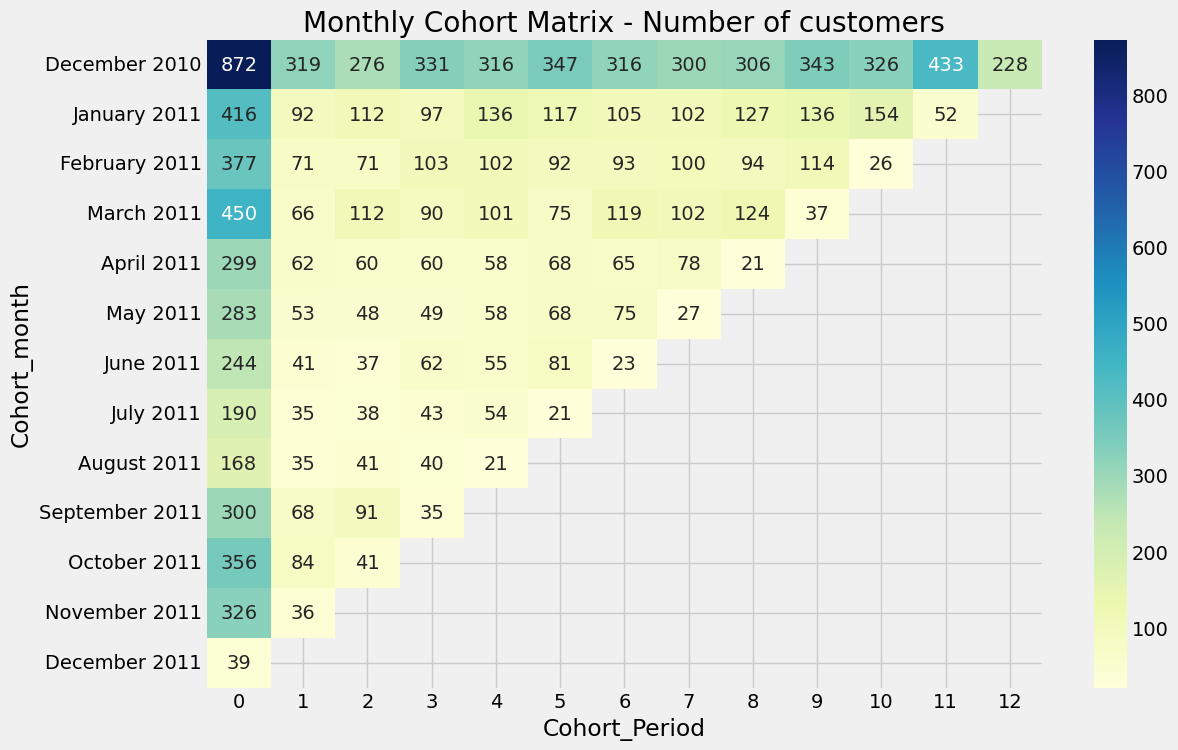

In [ ]:
#getting number of unique number of customer by grouping cohort period and month
cohort_table = df.groupby(['Cohort_month', 'Cohort_Period']).agg({'CustomerID': pd.Series.nunique}).reset_index()


##pivot table creation
'''
             The rows of the pivot table consist of the beginning of user activity or
             the month from which the user has started visiting the ecommerce website or
             has made the first purchase. The columns represent the user’s retention rate
             or how long has the user been coming back to purchase since his first time.

            '''
plt.figure(figsize=(12, 8))
heatmap_data = cohort_table.pivot(index='Cohort_month', columns='Cohort_Period', values='CustomerID')
heatmap_data.index = heatmap_data.index.strftime('%B %Y')

sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Monthly Cohort Matrix - Number of customers')
plt.show()

##Retention rate: (Metric of cohort analysis)
the percentage of individuals in a cohort who continue to engage with the product or service over a given period. This can be used to understand how well a product or service retains customers over time

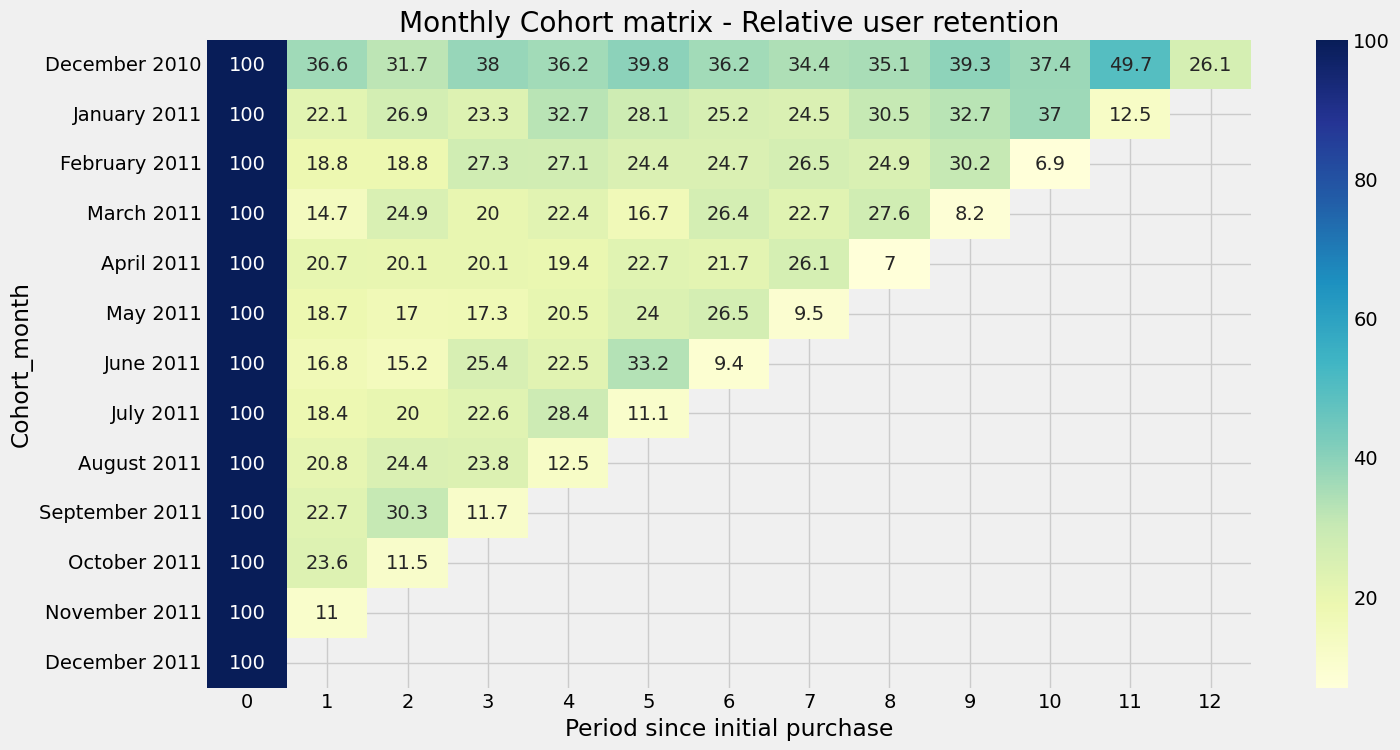

In [ ]:
#Retention table: retention gives you percentage of active customers compared to total number of customers
cohort_size = heatmap_data.iloc[:,0]
retention= heatmap_data.divide(cohort_size,axis=0)*100
retention = retention.round(1)


plt.figure(figsize=(15,8))
ax=plt.axes()
sns.heatmap(data=retention,annot=True,cmap='YlGnBu', fmt='g')
ax.set_title("Monthly Cohort matrix - Relative user retention")
ax.set_xlabel('Period since initial purchase')

plt.show()

##Interpreting cohort matrix:
1. The rows show us how the activity of the cohort has changed as they all age from the period of their first purchase.
2. The columns tell us how different cohorts compare to each other at the same relative "age" (e.g. periods since their first purchase).
3. The diagonals on a relative retention matrix highlights each cohort's behavior in the same calendar month.

##Average order value (AOV):(metric for cohort analysis)
the average value of an individual’s purchases. This metric can be used to understand the value of different segments of customers and identify opportunities for upselling or cross-selling.

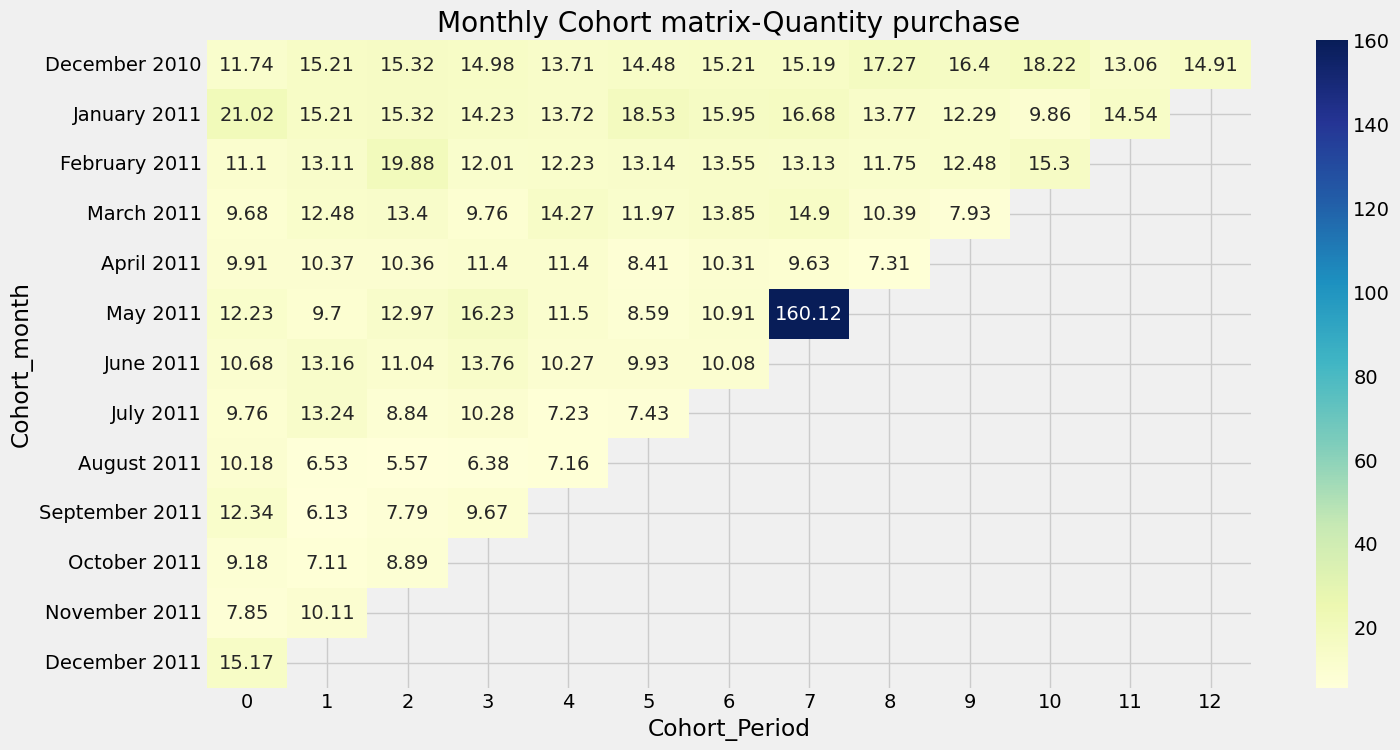

In [ ]:
#Average quantity for each cohort
aov_table = df.groupby(['Cohort_month','Cohort_Period']).agg({'Quantity':'mean'}).reset_index()

#pivot table
heat_map_table = aov_table.pivot(index='Cohort_month',columns='Cohort_Period',values='Quantity').round(2)
# changing index of the cohort table
heat_map_table.index = heat_map_table.index.strftime('%B %Y')

#visualizing aov
plt.figure(figsize=(15,8))
plt.title("Monthly Cohort matrix-Quantity purchase")
sns.heatmap(data=heat_map_table,annot=True,cmap='YlGnBu', fmt='g')
plt.show()


#Data Modeling :

* Build a RFM (Recency Frequency Monetary) model. `Recency` means the number of days since a customer made the last purchase.
`Frequency` is the number of purchase in a given period. It could be 3 months, 6 months or 1 year. `Monetary` is the total amount of money a customer spent in that given period. Therefore, big spenders will be differentiated among other customers such as MVP (Minimum Viable Product) or VIP.

* Calculate RFM metrics.
Build RFM Segments. Give recency, frequency, and monetary scores individually by dividing them into quartiles.

1. Combine three ratings to get a RFM segment (as strings).

2. Get the RFM score by adding up the three ratings.

3. Analyze the RFM segments by summarizing them and comment on the findings.

Note: Rate “recency" for customer who has been active more recently higher than the less recent customer, because each company wants its customers to be recent.

Note: Rate “frequency" and “monetary" higher, because the company wants the customer to visit more often and spend more money.

* To know more about rfm analysis : [refer]('https://clevertap.com/blog/rfm-analysis/')



[link text](https://)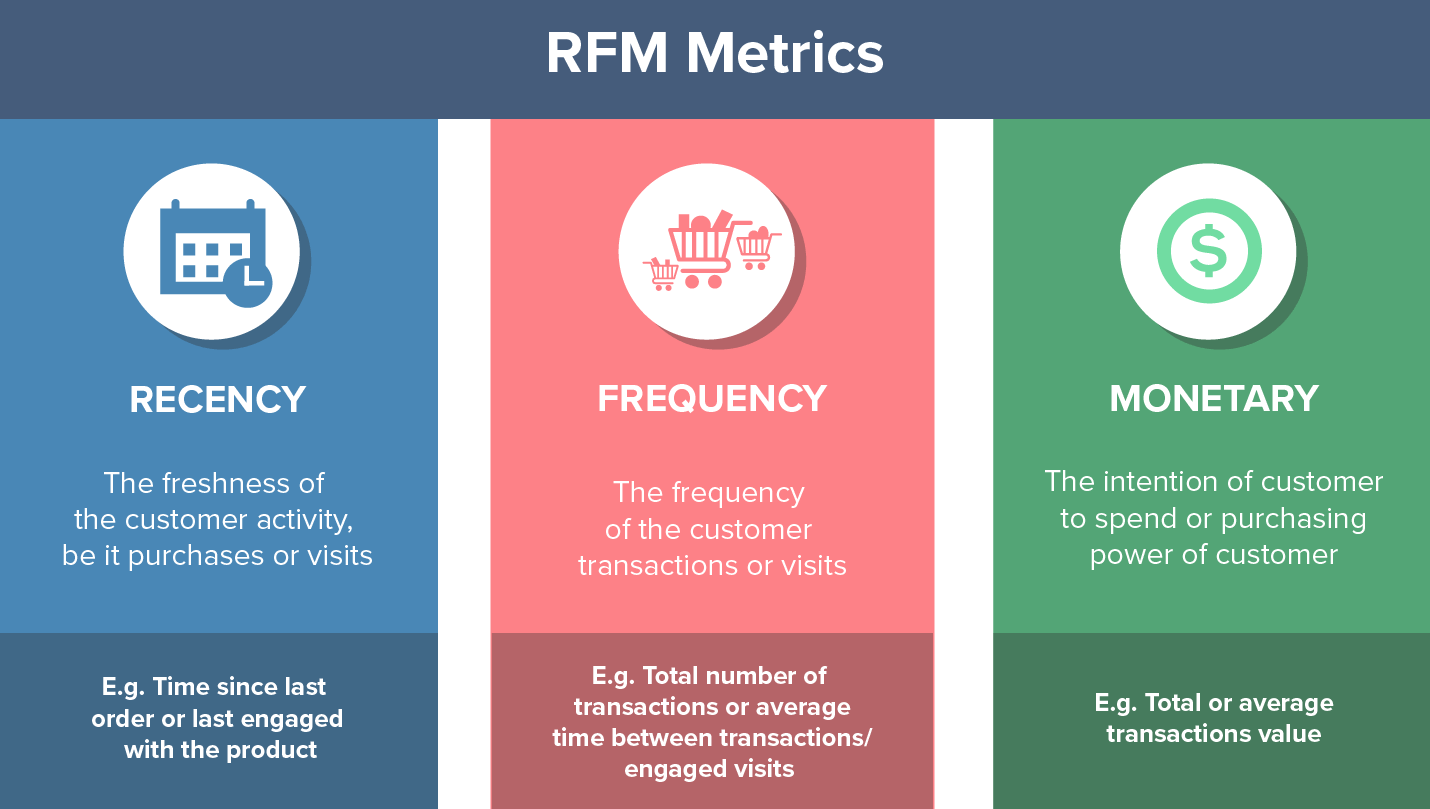

In [ ]:
#Recency,Frequency,Monetary

#calculating the latest date +1 day
current_date = df['InvoiceDate'].max()+dt.timedelta(days=1)

#calculting the total amount the customer spent
df['TotalSum'] = df['UnitPrice']*df['Quantity']

'''DataFrame, aggregating information such as the number of days since the
   last invoice, the count of invoices, and the total sum.

   1. InvoiceDate': lambda x: (current_date - x.max()).days--->
                This calculates the number of days since the last invoice
                for each customer by taking the maximum 'InvoiceDate' within each
                group (customer) and subtracting it from the current_date.
                This assumes that 'InvoiceDate' is a datetime column.

    2. 'InvoiceNo': 'count'--->This counts the number of invoices for each customer.

    3.'TotalSum': 'sum' --->This calculates the total sum of the 'TotalSum' column for each customer.
'''

rfm = df.groupby('CustomerID').agg({'InvoiceDate':lambda x:(current_date-x.max()).days,
                                    'InvoiceNo':'count',
                                    'TotalSum':'sum'})

rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalSum':'Monetary_value'},inplace=True)
#rfm dataframe : for every unique customer we have there recency, frequency and monetary value

rfm.head(2)

,Recency,Frequency,Monetary_value
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,132,3124.96


In [ ]:
print("Maximum days since a customer made purchase = " ,max(rfm['Recency']))
print("Maximum number of times a customer made purchase = " ,max(rfm['Frequency']))
print("Maximum amount a customer spent  = " ,max(rfm['Monetary_value']))
print()
print('*'*90)
print()
print("Minimum days since a customer made purchase = " ,min(rfm['Recency']))
print("Minimum number of times a customer made purchase = " ,min(rfm['Frequency']))
print("Minimum amount a customer spent  = " ,min(rfm['Monetary_value']))

Maximum days since a customer made purchase =  374
Maximum number of times a customer made purchase =  5413
Maximum amount a customer spent  =  190759.92

******************************************************************************************

Minimum days since a customer made purchase =  1
Minimum number of times a customer made purchase =  1
Minimum amount a customer spent  =  1.9


In [ ]:
'''Assigning labels to the customer based on the rfm levels

    For RECENCY: 1-4 segments where '1' being the most recent purchase made
                                     '4' being the customer who purchased item
                                      many days before

    for FREQUENCY AND MONETARY: 4-1 WHERE '1' being the least frequent & less money spent
                                           '4' being the more frequent & more money spent
'''


#dividing segments into quartiles
rfm['R'] = pd.qcut(rfm['Recency'],q=5, labels=[5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'),q=5, labels=[1,2,3,4,5])
rfm['M'] = pd.qcut(rfm['Monetary_value'].rank(method='first'),q=5, labels=[1,2,3,4,5])


#function for rfm segment


rfm['RFM_score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)


rfm.head()

,Recency,Frequency,Monetary_value,R,F,M,RFM_score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,132,3124.96,5,5,5,555
12348.0,75,20,1009.88,2,2,4,224
12349.0,19,50,1344.17,4,4,4,444
12350.0,310,11,213.30,1,2,2,122


Segmenting Customers based on RFM segment:
1. ` Champions` are your best customers, who bought most recently, most often, and are heavy spenders. Reward these customers. They can become early adopters for new products and will help promote your brand.
2. `Potential Loyalists` are your recent customers with average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.
3. `New Customers` are your customers who have a high overall RFM score but are not frequent shoppers. Start building relationships with these customers by providing onboarding support and special offers to increase their visits.
4. `At Risk Customers` are your customers who purchased often and spent big amounts, but haven’t purchased recently. Send them personalized reactivation campaigns to reconnect, and offer renewals and helpful products to encourage another purchase.
5. `Can’t Lose` Them are customers who used to visit and purchase quite often, but haven’t been visiting recently. Bring them back with relevant promotions, and run surveys to find out what went wrong and avoid losing them to a competitor.

In [ ]:
seg_map = {
    r'[1-2][1-2]':'Hibernating',
    r'[1-2][3-4]':'At Risk',
    r'[1-2]5': "Can't loose",
    r'3[1-2]':'About to sleep',
    r'33':'Need attention',
    r'[3-4][4-5]':'Loyal Customers',
    r'41':'Promising',
    r'51':'New Customers',
    r'[4-5][2-3]':'Potential Loyal',
    r'5[4-5]':'Champions'
}

rfm['Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str)
rfm['Segment'] = rfm['Segment'].replace(seg_map,regex=True)
rfm.head(2)

,Recency,Frequency,Monetary_value,R,F,M,RFM_score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Hibernating
12347.0,2,132,3124.96,5,5,5,555,Champions


In [ ]:
rfm_stats = rfm[['Segment','Recency','Frequency','Monetary_value']].groupby('Segment').agg({"mean",
                                                                                "median",
                                                                                "count",
                                                                                "std"})

rfm_stats.columns = rfm_stats.columns.map('_'.join).str.strip('|')

rfm_stats

,Recency_mean,Recency_std,Recency_count,Recency_median,Frequency_mean,Frequency_std,Frequency_count,Frequency_median,Monetary_value_mean,Monetary_value_std,Monetary_value_count,Monetary_value_median
Segment,,,,,,,,,,,,
About to sleep,54.091483,10.962010,317,53.0,11.072555,5.446324,317,11.0,313.999527,429.483760,317,213.960
At Risk,167.679931,83.348923,578,145.0,39.577855,15.941129,578,36.0,689.857284,716.533722,578,527.230
Can't loose,144.837500,71.293198,80,122.0,127.000000,50.247237,80,107.5,1674.977013,1262.981391,80,1476.735
Champions,6.053156,3.879272,602,5.0,202.534884,372.422469,602,119.0,4850.475731,13979.278105,602,1858.230
Hibernating,212.554919,88.819314,1047,213.0,9.381089,5.595592,1047,9.0,421.269656,2893.732822,1047,187.400
Loyal Customers,34.231618,15.728183,816,30.0,108.589461,83.766777,816,82.0,1977.227904,3981.707126,816,1235.340
Need attention,52.712195,11.353504,205,53.0,29.258537,5.683351,205,29.0,626.790244,776.642117,205,507.800
New Customers,6.943396,3.494034,53,8.0,5.660377,2.752226,53,6.0,3682.877170,23106.610179,53,138.660
Potential Loyal,16.272374,9.431384,514,17.0,24.227626,8.872100,514,24.0,640.970839,1378.408329,514,409.490


In [ ]:
rfm.head()

,Recency,Frequency,Monetary_value,R,F,M,RFM_score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,Hibernating
12347.0,2,132,3124.96,5,5,5,555,Champions
12348.0,75,20,1009.88,2,2,4,224,Hibernating
12349.0,19,50,1344.17,4,4,4,444,Loyal Customers
12350.0,310,11,213.30,1,2,2,122,Hibernating


In [ ]:
# Count the number of customers for each segment
rfm = rfm.reset_index()
segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'CustomerCount']

# Create a treemap with the number of customers
fig = px.treemap(segment_counts,
                 path=['Segment'],
                 values='CustomerCount',
                 title='Number of Customers in Each Segment',
                 color='Segment',
                 color_continuous_scale='Viridis',
                 hover_data=['Segment'])

# Show the treemap
fig.show()

# Data preprocessing for KMeans Clustering

In [ ]:
rfm_data = rfm[['Recency','Frequency','Monetary_value']]

rfm_data.describe()

,Recency,Frequency,Monetary_value
count,4320.000000,4320.000000,4320.000000
mean,93.019213,63.932870,1455.412403
std,100.373017,158.847859,6427.404543
min,1.000000,1.000000,1.900000
25%,18.000000,12.000000,210.082500
50%,51.000000,29.000000,479.460000
75%,144.000000,70.000000,1180.405000
max,374.000000,5413.000000,190759.920000


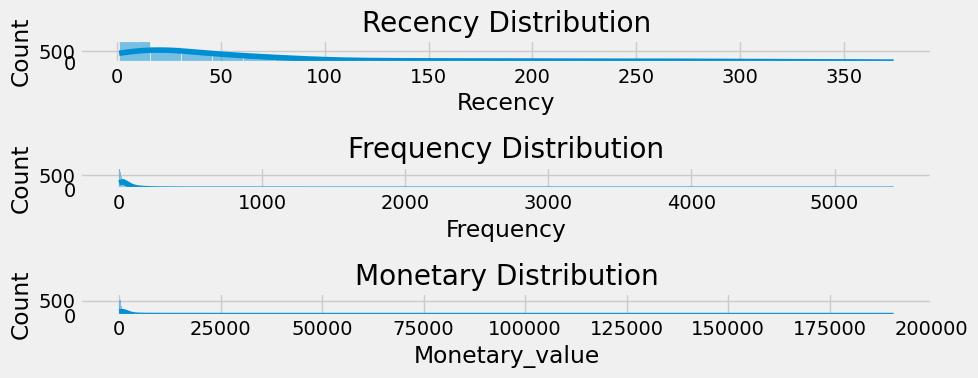

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(10, 4))

# Plot Recency distribution
sns.histplot(rfm_data['Recency'], kde=True, ax=ax[0])
ax[0].set_title('Recency Distribution')

# Plot Frequency distribution
sns.histplot(rfm_data['Frequency'], kde=True, ax=ax[1])
ax[1].set_title('Frequency Distribution')

# Plot Monetary distribution
sns.histplot(rfm_data['Monetary_value'], kde=True, ax=ax[2])
ax[2].set_title('Monetary Distribution')

# Adjust layout
plt.tight_layout()

The graph for all the above distributions is skewed towards the right, to make the distribution symmetric

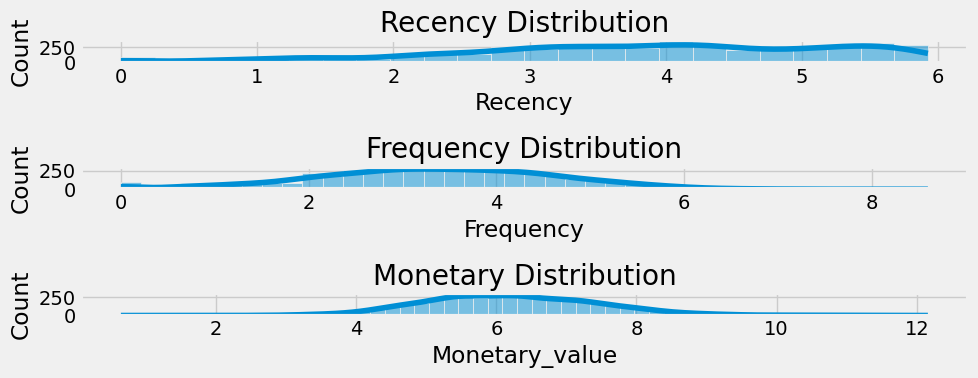

In [ ]:
#applying log transform to make data distribution symmetric
rfm_log = rfm_data[['Recency','Frequency','Monetary_value']].apply(np.log,axis=1).round(3)


#Visulaizing the distribution after transformation
f, ax = plt.subplots(3, 1, figsize=(10, 4))

# Plot Recency distribution
sns.histplot(rfm_log['Recency'], kde=True, ax=ax[0])
ax[0].set_title('Recency Distribution')

# Plot Frequency distribution
sns.histplot(rfm_log['Frequency'], kde=True, ax=ax[1])
ax[1].set_title('Frequency Distribution')

# Plot Monetary distribution
sns.histplot(rfm_log['Monetary_value'], kde=True, ax=ax[2])
ax[2].set_title('Monetary Distribution')

plt.style.use('fivethirtyeight')
# Adjust layout
plt.tight_layout()

In [ ]:
#standardizing the data so that every feature is the same scale
scaler= StandardScaler()
rfm_standard = scaler.fit_transform(rfm_log)

Choosing Number of clusters(k-value):
1. Elbow Method:
   * Plot the sum of squared distances (inertia) for different values of k.
  * Look for the "elbow" point on the plot, where the rate of decrease in inertia sharply changes.
  * The elbow point is a good estimate for the optimal k value.

2. Silhouette Score:
  * Calculate the silhouette score for different values of k.
  * Choose the k value that gives the highest silhouette score.
  * Silhouette score measures how similar an object is to its own cluster compared to other clusters.

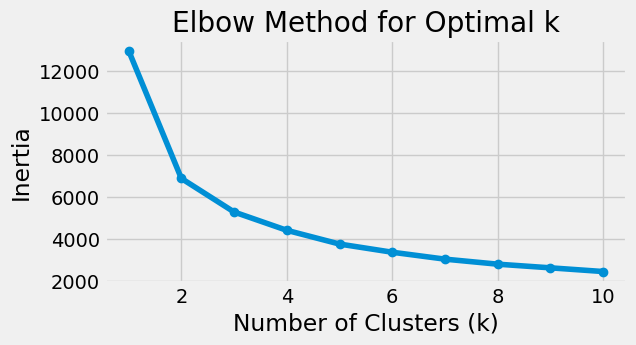

In [ ]:
#elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10,random_state=42)
    kmeans.fit(rfm_standard)
    inertias.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(6,3))
plt.plot(range(1, 11), inertias,
marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

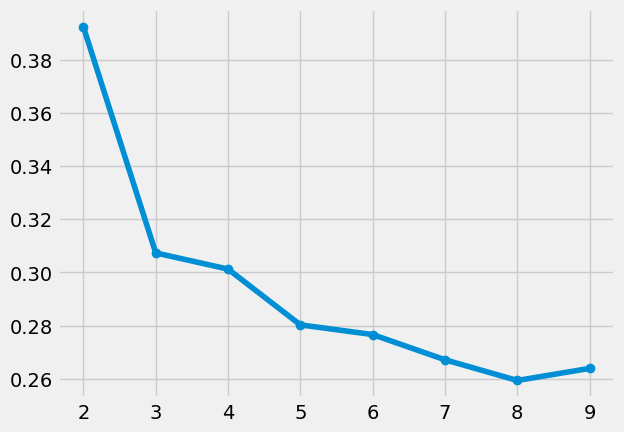

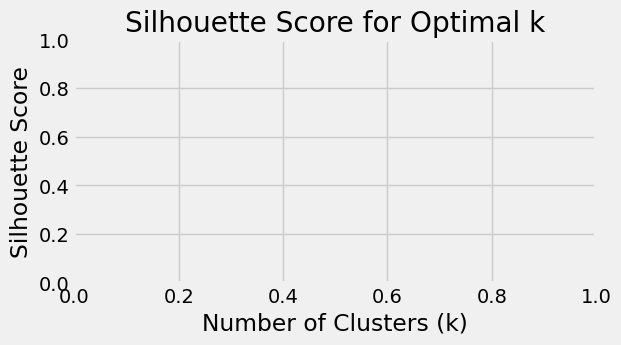

In [ ]:
#silhouette_score
silhouette_scores = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    labels = kmeans.fit_predict(rfm_standard)
    silhouette_scores.append(silhouette_score(rfm_standard, labels))

# Plotting silhouette scores
plt.figure(figsize=(6,3))
plt.plot(range(2,10), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

Considering the optimal value of k=3

In [ ]:
kmeans = KMeans(n_clusters=3,n_init=10,random_state=42)
labels = kmeans.fit_predict(rfm_standard)

#adding labels to the original dataframe
rfm_labels = rfm_data.assign(K_cluster=labels)

In [ ]:
#calculting average RFM values and size for each cluster

rfm_labels.groupby(['K_cluster']).agg({'Recency':'mean',
                                       'Frequency':'mean',
                                       'Monetary_value':['mean','count']}).round(0)

Recency Frequency Monetary_value      
             mean      mean           mean count
K_cluster                                       
0           169.0      11.0          204.0  1548
1            13.0     186.0         4713.0   924
2            69.0      47.0          875.0  1848

In [ ]:
rfm_standard = pd.DataFrame(rfm_standard, index=rfm_data.index,columns=rfm_data.columns)
rfm_standard['K_cluster'] = kmeans.labels_
rfm_standard['Segments'] = rfm['Segment']
rfm_standard['CustomerID'] = rfm['CustomerID']

rfm_standard.reset_index(inplace=True)

#converting wide format to long format
rfm_melt = pd.melt(rfm_standard,
                   id_vars=['CustomerID','Segments','K_cluster'],
                   value_vars=['Recency','Frequency','Monetary_value'],
                   var_name='Metric',
                   value_name='Value')

rfm_melt.head()

,CustomerID,Segments,K_cluster,Metric,Value
0,12346.0,Hibernating,2,Recency,1.406070
1,12347.0,Champions,1,Recency,-2.150811
2,12348.0,Hibernating,2,Recency,0.379644
3,12349.0,Loyal Customers,2,Recency,-0.579052
4,12350.0,Hibernating,0,Recency,1.371158


##Data Visualization:
Implementing snake plot:


*  data visualization technique used to visualize multivariate data.
*   It is particularly useful for comparing the patterns or trends across multiple variables for different observations or groups.
*  Snake plots are commonly used in marketing and market research to analyze and compare the behavior of different segments or clusters.

Here we compare differnt clusters



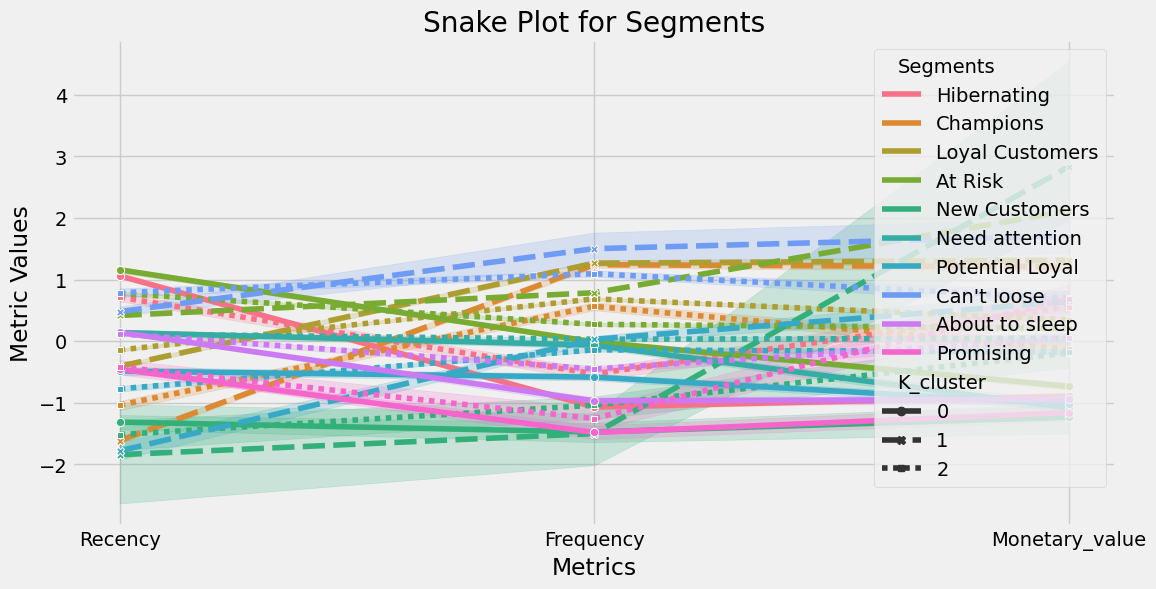

In [ ]:
# Create a snake plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Metric', y='Value', hue='Segments', style='K_cluster', data=rfm_melt, markers=True)

# Add title and labels
plt.title('Snake Plot for Segments')
plt.xlabel('Metrics')
plt.ylabel('Metric Values')

# Show the plot
plt.show()

In [ ]:
#To visulaize how many customers present in each cluster
pd.crosstab(rfm_melt.Metric,rfm_melt.K_cluster,margins=True).style.background_gradient(cmap='summer_r')

K_cluster,0,1,2,All
Metric,,,,
Frequency,1548,924,1848,4320
Monetary_value,1548,924,1848,4320
Recency,1548,924,1848,4320
All,4644,2772,5544,12960


In [ ]:
pd.crosstab(index=rfm_melt['Segments'], columns=[rfm_melt['K_cluster'], rfm_melt['Metric']], margins=True).style.background_gradient(cmap='summer_r')
